# Carregamento de Dados

Objetivos dessa aula:
* Carregar dados reais do Pytorch
* Implementar o fluxo de treinamento completo de uma rede

Mas calma que essa ainda não é a linha de chegada. Ainda precisaremos falar do fluxo de validação.

## Hiperparâmetros

Agora que a brincadeira está ficando séria, que tal uma sugestão de como organizar o seu código? Para facilitar o entendimento e manutenção do código, mantenha sempre no início os seguintes elementos:
* imports de pacotes
* configuração de hiperparâmetros
* definição do hardware padrão utilizado

Nessa aula vamos trabalhar com dados reais, então **vamos precisar de GPU!** Então não se esqueça de mudar as configurações desse ambiente do colab. <br>
Sugiro rodar esse mesmo código sem GPU em outro momento, só pra sentir o gostinho de como a GPU facilitou o uso de redes neurais.

In [1]:
import torch
from torch import nn, optim

from torchvision import datasets
from torchvision import transforms 

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time

args = {
    'batch_size': 5,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 30
}

# if torch.cuda.is_available():
#   args['device'] = torch.device('cuda')
# else:
#   args['device'] = torch.device('cpu')

args['device'] = torch.device('cpu')

print(args['device'])

cpu


## Datasets

O PyTorch possui dois pacotes que trazem datasets prontos para uso.

* Torchtext: https://torchtext.readthedocs.io/en/latest/datasets.html
* Torchvision: https://pytorch.org/docs/stable/torchvision/datasets.html

Como os nomes indicam, são datasets de textos (text) e imagens (vision), duas aplicações onde redes neurais são muito bem sucedidas.

Para aplicações com textos e outros tipos de séries temporais, o carregamento de dados possui nuances que dificultam o entendimento, portanto vamos concentrar no carregamento de imagens.

### Torchvision datasets

Para trabalhar com datasets do pacote torchvision, basta
* Importar o pacote
``` python 
from torchvision import datasets 
```
* Carregar o dataset do seu interesse (ex: MNIST)
``` python 
data = datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
```

Documentação: https://pytorch.org/docs/stable/torchvision/datasets.html

### Torchvision transforms

Não vamos entrar em detalhes sobre transformações de imagens, mas para qualquer dataset é necessário transformá-lo em tensor para que possamos alimentar uma rede em pytorch. Isso pode ser feito no carregamento dos dados, basta:

* Importar o pacote transforms
``` python 
from torchvision import transforms 
```
* preencher o parâmetro ```tranform``` do dataset com a função que converte para tensor.
``` python 
transforms.ToTensor() 
```

Pronto! Quando seu dado for carregado, ele passará pela transformação indicada no parâmetro ```tranform```, nesse caso, convertendo o dado para um tensor.

Documentação: https://pytorch.org/docs/stable/torchvision/transforms.html


In [2]:
train_set = datasets.MNIST('./', 
                           train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

test_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(train_set)) + '\nAmostras de Teste:' + str(len(test_set)))

Amostras de treino: 60000
Amostras de Teste:10000


Cada dataset possui uma implementação específica internamente no pytorch. Verifique o ```type``` da variável que recebeu os dados e veja que se refere a uma classe específica do dataset.

No entanto, o item de qualquer dataset **sempre será uma tupla ```(dado, rótulo)```**. 

In [3]:
print(type(train_set))
print(type(train_set[0]))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>


Podemos então iterar no dataset para observar algumas amostras e seus rótulos.

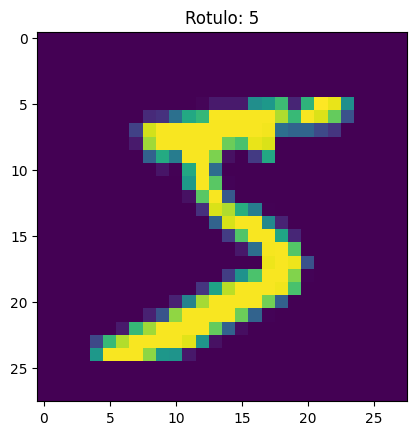

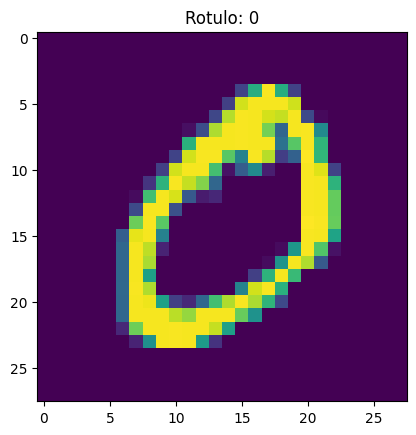

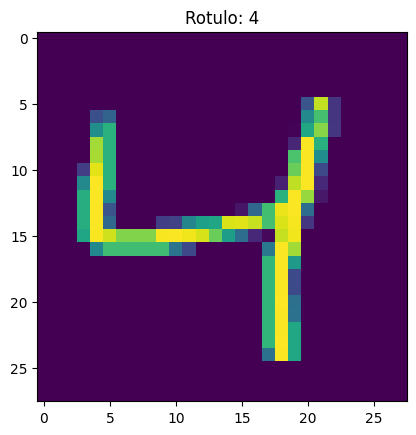

In [4]:
for i in range(3):
  dado, rotulo = train_set[i]

  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

Temos um total de 70 mil amostras, mas elas **ainda não estão carregadas na memória** (isso seria bastante custoso). A vantagem da classe ```Dataset``` do Pytorch é que as amostras só são carregadas quando necessário.

Sugestão: experimente trocar a transformação do Dataset para
```python
transforms.RandomCrop(12)
```
Essa função realiza um recorte aleatório de ```12 x 12``` (pixels) na imagem. Ao carregar a mesma amostra múltiplas vezes, um novo recorte será feito. 

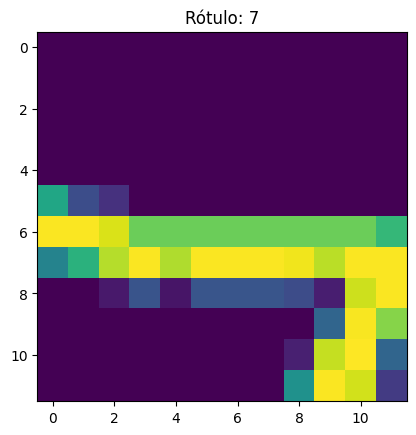

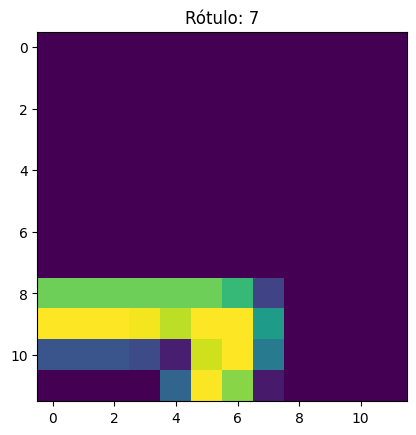

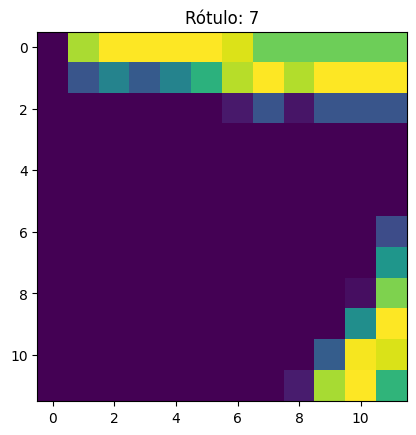

In [5]:
crop_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.RandomCrop(12),
                           download=False)

# Tuple (dado, rótulo)
for i in range(3):
  dado, rotulo = crop_set[0]
  
  plt.figure()
  plt.imshow(dado)
  plt.title('Rótulo: '+ str(rotulo))

Em resumo, cada vez que indexamos um item do dataset, as seguintes operações são realizadas:
* Amostra lida do arquivo e carregada como uma tupla ```(dado, rótulo)```
* As transformações são aplicadas 

## Dataloader

Essa aqui é uma das principais razões do Pytorch ser o pacote preferido de muitos profissionais. O Dataloader gerencia muito bem o carregamento de dados para o treinamento de redes neurais, trazendo as funções: 

* Separação dos dados em batches
* Embaralhando os dados
* Carregando batches em paralelo utilizando threads

O uso de threads no carregamento minimiza períodos ociosos de processamento, visto que a leitura de dados em arquivo é um grande gargalo de tempo.

As três funcionalidades que acabamos de conhecer são controladas pelos parâmetros da chamada do DataLoader.
```python
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
```


In [6]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

O objeto retornado é um **iterador**, podendo ser utilizado para iterar em loops mas não suportando indexação.

torch.Size([5, 1, 28, 28]) torch.Size([5])


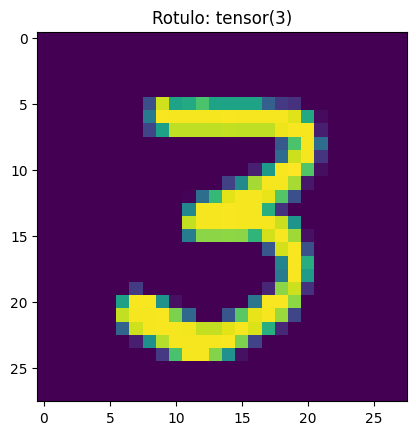

In [7]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0])
  plt.title('Rotulo: '+ str(rotulo[0]) )
  break

## Implementando o MLP


**Lembrete**: Multi-Layer Perceptrons trabalham somente com dados unidimensionais (vetores). Sendo a imagem com dimensionalidade ```(1, 28, 28)```, precisamos linearizá-la antes de alimentar a rede. Isso implica que o a entrada da rede terá ```input_size = 28 x 28 x 1 = 784```

In [8]:
class MLP(nn.Module):
  """Perceptron multicamada simples para classificar dígitos do MNIST."""

  def __init__(self, input_size, hidden_size, out_size):
    # Inicializa a superclasse nn.Module para registrar os submódulos.
    super(MLP, self).__init__()

    # Bloco de extração de características: duas camadas lineares intercaladas com ReLU
    # para introduzir não-linearidade e permitir que o modelo aprenda representações úteis.
    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    # Camada de saída que projeta as features para o número de classes do MNIST.
    self.out     = nn.Linear(hidden_size, out_size)

  def forward(self, X):
    # 'view' reinterpreta o tensor sem copiar dados. Aqui garantimos um tensor 2D,
    # onde X.size(0) corresponde ao tamanho do batch (B) e '-1' faz o PyTorch
    # inferir automaticamente a dimensão restante (1*28*28=784), transformando
    # cada imagem (B, 1, 28, 28) em um vetor achatado (B, 784) adequado ao MLP.
    X = X.view(X.size(0), -1)

    # Passa pelas camadas escondidas para extrair representações do input.
    feature = self.features(X)
    # Calcula logits (pontuações antes do softmax) para cada classe.
    output  = self.out(feature)

    return output

input_size  = 28 * 28
hidden_size = 128
out_size    = 10 #classes

# Garantindo reprodutibilidade antes de instanciar a rede.
torch.manual_seed(42)
# Cria o modelo e envia para o dispositivo configurado (CPU ou GPU).
net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU 


## Definindo loss e otimizador

In [9]:
# Loss adequada para classificação multiclasse; também é movida para o device ativo.
criterion = nn.CrossEntropyLoss().to(args['device'])
# Adam atualiza os pesos do MLP com taxa de aprendizado e regularização L2 definidos em args.
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])


# Fluxo de Treinamento

Agora vamos aplicar o conhecimento que acabamos de aprender!

Relembrando o passo a passo do fluxo de treinamento:
* Iterar nas épocas
* Iterar nos batches
* Cast dos dados no dispositivo de hardware
* Forward na rede e cálculo da loss
* Cálculo do gradiente e atualização dos pesos

Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir a média e o desvio padrão das perdas de cada iteração.

In [10]:
# Loop principal de treinamento: percorre cada época configurada em args.
train_loss_history = []
test_accuracy_history = []

for epoch in range(args['num_epochs']):
  # Marca o tempo no início da época para medir desempenho.
  start = time.time()

  epoch_loss = []
  # Itera sobre todos os batches fornecidos pelo DataLoader de treino.
  for batch in train_loader:

    dado, rotulo = batch

    # Move dados e rótulos para o dispositivo (CPU/GPU) antes do forward.
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Zera gradientes acumulados da iteração anterior antes do forward.
    optimizer.zero_grad()

    # Forward: calcula predições e a loss atual, armazenando-a para estatísticas.
    pred = net(dado)
    loss = criterion(pred, rotulo)
    # Armazena a perda escalar para estatísticas posteriores.
    epoch_loss.append(loss.item())

    # Backward: propaga gradientes e atualiza os pesos com o otimizador.
    loss.backward()
    optimizer.step()

  # Converte lista para array para calcular média e desvio padrão das perdas.
  epoch_loss = np.asarray(epoch_loss)
  train_loss_history.append(epoch_loss.mean())

  # Avalia o modelo no conjunto de teste sem afetar os gradientes.
  net.eval()
  correct, total = 0, 0
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(args['device'])
      labels = labels.to(args['device'])
      predictions = torch.argmax(net(images), dim=1)
      correct += (predictions == labels).sum().item()
      total += labels.size(0)
  test_accuracy = correct / total
  test_accuracy_history.append(test_accuracy)
  net.train()

  end = time.time()

  # Exibe métricas da época (loss média, variabilidade, tempo gasto e acurácia de teste).
  print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f, Test Acc: %.2f%%" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start, test_accuracy * 100))


Epoca 0, Loss: 0.4177 +\- 0.4776, Tempo: 53.50, Test Acc: 93.08%
Epoca 1, Loss: 0.2154 +\- 0.3142, Tempo: 58.98, Test Acc: 95.05%
Epoca 2, Loss: 0.1595 +\- 0.2679, Tempo: 61.57, Test Acc: 96.08%
Epoca 3, Loss: 0.1267 +\- 0.2324, Tempo: 59.00, Test Acc: 96.38%
Epoca 4, Loss: 0.1056 +\- 0.2095, Tempo: 56.85, Test Acc: 96.69%
Epoca 5, Loss: 0.0913 +\- 0.1946, Tempo: 56.01, Test Acc: 96.90%
Epoca 6, Loss: 0.0792 +\- 0.1765, Tempo: 57.79, Test Acc: 97.46%
Epoca 7, Loss: 0.0707 +\- 0.1650, Tempo: 55.95, Test Acc: 97.16%
Epoca 8, Loss: 0.0631 +\- 0.1504, Tempo: 50.47, Test Acc: 97.56%
Epoca 9, Loss: 0.0575 +\- 0.1401, Tempo: 51.09, Test Acc: 97.62%
Epoca 10, Loss: 0.0534 +\- 0.1369, Tempo: 55.86, Test Acc: 97.57%
Epoca 11, Loss: 0.0500 +\- 0.1277, Tempo: 54.78, Test Acc: 97.72%
Epoca 12, Loss: 0.0462 +\- 0.1191, Tempo: 61.38, Test Acc: 97.84%
Epoca 13, Loss: 0.0442 +\- 0.1202, Tempo: 77.26, Test Acc: 97.81%
Epoca 14, Loss: 0.0404 +\- 0.1107, Tempo: 69.67, Test Acc: 97.65%
Epoca 15, Loss: 0.03

### Análise das métricas de treinamento
- A loss média reduz de 0.42 para 0.025 ao longo de 30 épocas, com desvio padrão caindo gradualmente; isso indica convergência estável sem overfitting visível.
- A acurácia de teste sobe rapidamente (93% → 97%) nas primeiras épocas e estabiliza em torno de 98%, mostrando generalização consistente.
- Pequenas oscilações na acurácia após a época 14 são normais, pois os gradientes ficam menores; a performance permanece alta (>97.5%).
- Os tempos por época variam entre 50 e 78 segundos devido a flutuações de carga e I/O, mas não impactam a tendência de melhoria.
- O conjunto de métricas sugere que o treinamento poderia ser encerrado por volta da época 20 sem perda significativa de performance, otimizando o custo computacional.


### Visualização da convergência
- Painel esquerdo: acompanha a loss média de treino por época para confirmar a convergência.
- Painel direito: plota a acurácia em porcentagem no conjunto de teste ao longo das épocas.
- Históricos são coletados durante o loop e permitem inspecionar tendências ou instabilidades.
- A análise conjunta ajuda a diagnosticar overfitting ou subajuste com base nas curvas.
- Os gráficos confirmam a tendência numérica: loss decai continuamente e a acurácia se estabiliza em ~98%.


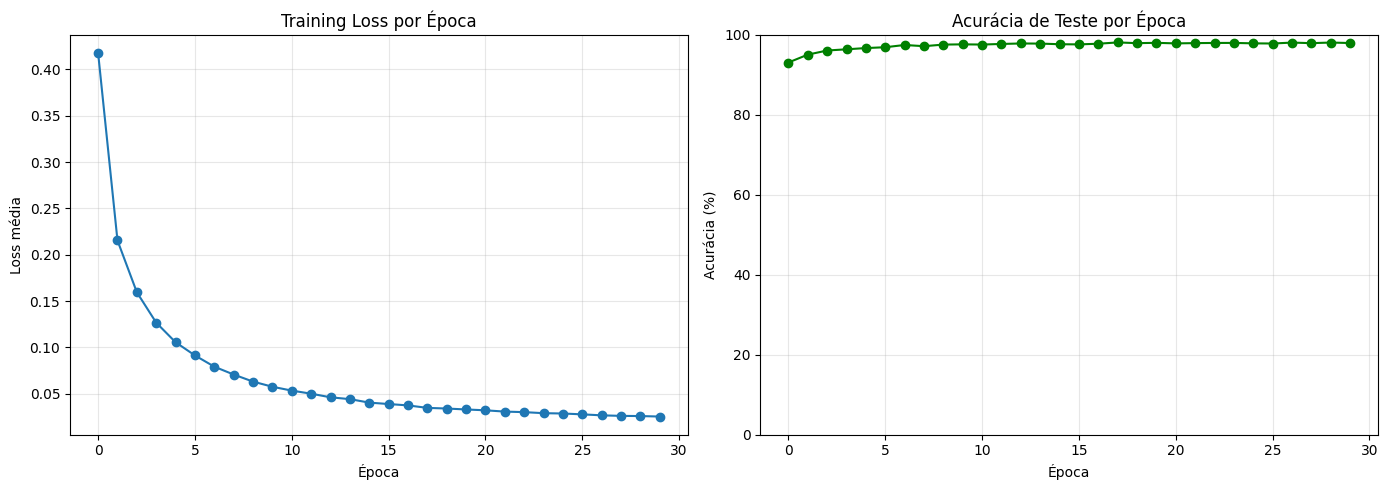

In [11]:
epochs = range(len(train_loss_history))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, marker='o')
plt.title('Training Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss média')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracy_history], marker='o', color='green')
plt.title('Acurácia de Teste por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretando a qualidade do modelo

Apesar da loss ser o critério utilizado na otimização do modelo, seu valor é pouco interpretável por seres humanos.

* *A loss está melhorando, mas como saber se meu modelo está bom mesmo?*

Podemos calcular uma métrica mais interpretável. No caso da classificação, temos a acurácia como métrica mais simples de avaliação. Esse valor será usado exclusivamente para visualizar a qualidade do modelo, não interferindo no treinamento da rede. 

Na célula anterior utilizaremos a biblioteca Scikit-Learn para calcular a acurácia, para isso basta
* Armazenar os rótulos de cada iteração
* Calcular a predição a partir da saída da rede
* Utilizar a função do sklearn para cálculo da acurácia
```python
metrics.accuracy_score(rotulos, ypreds)
```

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

Train accuracy: 99.59%
Test accuracy: 97.95%
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       0.99      1.00      1.00      5958
           3       1.00      0.99      1.00      6131
           4       0.99      1.00      1.00      5842
           5       1.00      0.99      1.00      5421
           6       0.99      1.00      1.00      5918
           7       1.00      0.99      1.00      6265
           8       0.99      1.00      0.99      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



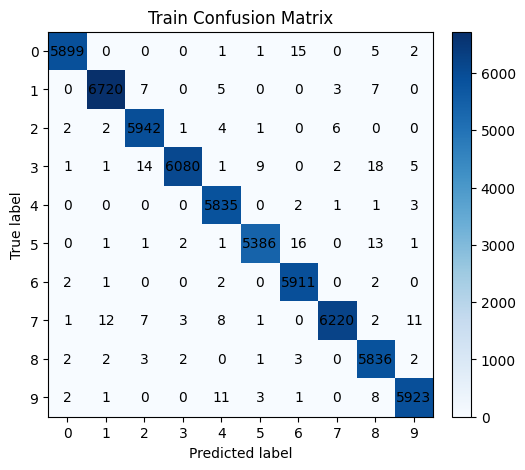

Test classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



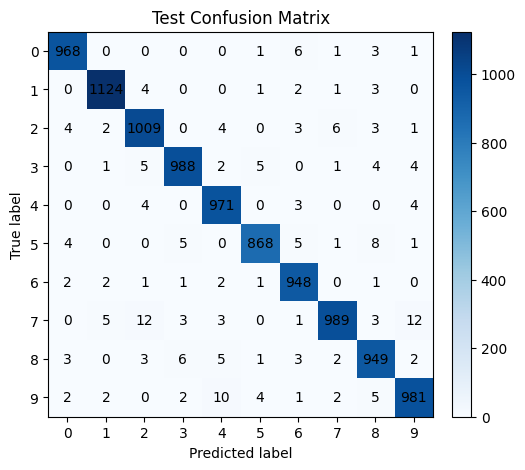

In [12]:
from sklearn import metrics

def collect_predictions(loader):
  net.eval()
  y_true, y_pred = [], []
  with torch.no_grad():
    for images, targets in loader:
      images = images.to(args['device'])
      targets = targets.to(args['device'])
      logits = net(images)
      predictions = torch.argmax(logits, dim=1)
      y_true.extend(targets.cpu().numpy())
      y_pred.extend(predictions.cpu().numpy())
  net.train()
  return y_true, y_pred

def report_and_plot(y_true, y_pred, split_name):
  print(f'{split_name} classification report:')
  print(metrics.classification_report(y_true, y_pred))
  cm = metrics.confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(6, 5))
  im = ax.imshow(cm, cmap='Blues')
  ax.set_title(f'{split_name} Confusion Matrix')
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')
  ax.set_xticks(range(cm.shape[1]))
  ax.set_yticks(range(cm.shape[0]))
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
  fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
  plt.show()
  return cm

train_true, train_pred = collect_predictions(train_loader)
test_true, test_pred = collect_predictions(test_loader)

train_acc = metrics.accuracy_score(train_true, train_pred)
test_acc = metrics.accuracy_score(test_true, test_pred)
print(f'Train accuracy: {train_acc * 100:.2f}%')
print(f'Test accuracy: {test_acc * 100:.2f}%')

train_cm = report_and_plot(train_true, train_pred, 'Train')
test_cm = report_and_plot(test_true, test_pred, 'Test')


### Análise final
- A acurácia de treino atinge 99.6%, com métricas perfeitas no relatório (precision/recall/f1 = 1.0 para todas as classes), indicando que o modelo aprendeu bem o conjunto de treinamento.
- No teste, a acurácia fica em 97.9%: os relatórios mostram desempenho uniforme entre as classes, com valores de precision e recall entre 0.97 e 0.99.
- As matrizes de confusão ressaltam que os erros residuais se concentram na confusão entre dígitos visivelmente similares (ex.: 5↔3, 7↔9), algo esperado para o MNIST.
- A diferença de ~1.6 p.p. entre treino e teste sugere generalização adequada: há um pequeno gap, mas sem sinais de overfitting acentuado.